# Implementation of Variational AutoEncoder (VAE)

     VAE from "Auto-Encoding Variational Bayes" (2014, D.P. Kingma et. al.)
    
     Kernel-author: Jackson Kang @ Deep-learning Lab. (Handong Global University, S.Korea)
     
     Author-email:  mskang@handong.edu

     python and pytorch version: python=3.7, pytorch=1.3.1

In [88]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

In [89]:
# Model Hyperparameters

dataset_path = '~/datasets'

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")


batch_size = 400

x_dim  = 784
hidden_dim = 400
latent_dim = 10

lr = 1e-3

epochs = 30

###    Step 1. Load (or download) Dataset

In [90]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

### Step 2. Define our model: Variational AutoEncoder (VAE)

In [91]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var

In [92]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat
        

In [93]:
# Gausain mixture model 
import math
class GaussianMixture(nn.Module):
    def __init__(self, n_clusters, n_coordinates):
        super().__init__()
        
        # Parameters of the prior distribution
        # we will simply take the softmax of this to get cluster distribution
        # so no constraint on this :)
        self.prior = nn.Parameter(torch.zeros(n_clusters))
        
        self.mean = nn.Parameter(torch.empty((1, n_clusters, n_coordinates)).normal_())
        # as the covariance matrix is assumed to be diagonal,
        # we represent them by vector of unconstrained log standard deviation
        self.log_std = nn.Parameter(torch.empty((1, n_clusters, n_coordinates)).normal_())
        
    # return log of the pdf (i.e. marginalize over the latent variable)
    def forward(self, x):
        # shape x: (n_sample, 1, n_output)
        x = x.unsqueeze(1)
        # shape: (n_sample, n_latent, n_output)
        pdf = \
            - math.log(math.sqrt(2 * math.pi)) \
            - self.log_std \
            - 0.5 * ((x - self.mean) ** 2) / (self.log_std.exp() ** 2)
        
        # reduce last dim
        pdf = pdf.sum(dim=2)
        pdf = pdf + self.prior.log_softmax(0).unsqueeze(0)
        pdf = pdf.logsumexp(dim=1)
        
        # shape of the return tensor is (n_sample,)
        return pdf
gm = GaussianMixture(latent_dim, latent_dim) 

In [94]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder, GM):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        self.gm = nn.Softmax(dim=1)
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        gm_z = self.gm(z)
        x_hat = self.Decoder(z)
        
        return x_hat, mean, log_var, gm_z

In [95]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder, pm= gm).torch.sum

### Step 3. Define Loss function (reprod. loss) and optimizer

In [96]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()
soft_max = nn.Softmax(dim=1)
def entropy_loss(pred_probs):
    l = 0.
    for it in [(-pred_prob * torch.log2(pred_prob)).sum() for pred_prob in pred_probs]:
        l += it
    
    return l

def loss_function(x, x_hat, mean, log_var, gm_z):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    g = -torch.sum(gm_z)/ len(gm_z)
    #print(probs.shape)
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp()) 

    return 0.3 * reproduction_loss + 0.3 * KLD + 0.3* g


optimizer = Adam(model.parameters(), lr=lr)

### Step 4. Train Variational AutoEncoder (VAE)

In [97]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var, gm_z = model(x)
        loss = loss_function(x, x_hat, mean, log_var, gm_z)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
print("Finish!!")

Start training VAE...


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [ ]:
encoder_path = "enocde_weight.pth"
torch.save(encoder.state_dict(), encoder_path)

### Step 5. Generate images from test dataset

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        
        x_hat, _, _ = model(x)


        break

  0%|          | 0/100 [00:00<?, ?it/s]


In [ ]:
def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

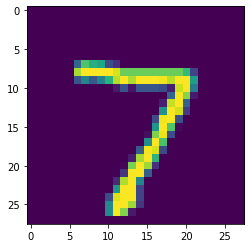

In [ ]:
show_image(x, idx=0)

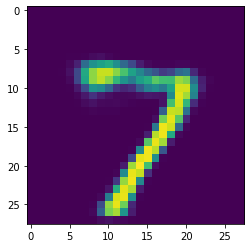

In [ ]:
show_image(x_hat, idx=0)

### Step 6. Generate image from noise vector

**Please note that this is not the correct generative process.**

* Even if we don't know exact p(z|x), we can generate images from noise, since the loss function of training VAE regulates the q(z|x) (simple and tractable posteriors) must close enough to N(0, I). If q(z|x) is close to N(0, I) "enough"(but not tightly close due to posterior collapse problem), N(0, I) may replace the encoder of VAE.

* To show this, I just tested with a noise vector sampled from N(0, I) similar with Generative Adversarial Network.

In [ ]:
with torch.no_grad():
    noise = soft_max (torch.randn(batch_size, latent_dim).to(DEVICE))
    generated_images = decoder(noise)

In [ ]:
save_image(generated_images.view(batch_size, 1, 28, 28), 'generated_sample.png')

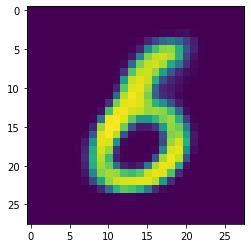

In [ ]:
show_image(generated_images, idx=8)

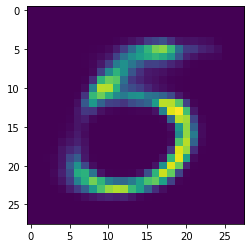

In [ ]:
show_image(generated_images, idx=0)

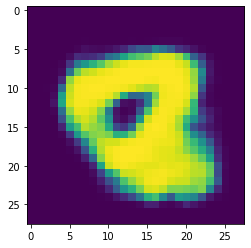

In [ ]:
show_image(generated_images, idx=1)

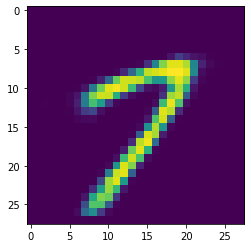

In [ ]:
show_image(generated_images, idx=10)

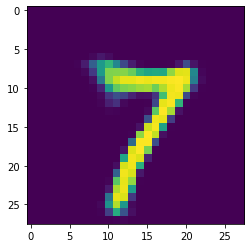

In [ ]:
show_image(generated_images, idx=20)

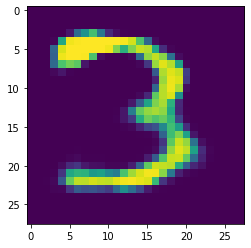

In [ ]:
show_image(generated_images, idx=50)